In [ ]:
# ----------------------------------------------
# Anomaly Detection with Anomalib: Setup Script
# ----------------------------------------------
# This script sets up environment, imports required modules,
# and prepares for anomaly detection using Anomalib models.
# ----------------------------------------------

import os
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import anomalib
from anomalib import TaskType
from anomalib.data import Folder
from anomalib.models import (
    Patchcore, Padim, Stfpm, Draem, EfficientAd, Fastflow, Cflow
)
from anomalib.deploy.inferencers import TorchInferencer

# Print Anomalib version and set seed
print("Anomalib version:", anomalib.__version__)
seed_everything(0)
torch.set_float32_matmul_precision('medium')


Seed set to 0


1.0.1


# Use `Folder` for Customs Datasets


In [2]:


datamodule = Folder(
    name="my_dataset",
    root=r"D:\Anomaly_detecion\hazelnut_toy",
    normal_dir="good",
    abnormal_dir="crack",  # only if you have it
    normal_split_ratio=0.1,
    image_size=(512, 512),
    train_batch_size=16,
    eval_batch_size=16,
    task=TaskType.CLASSIFICATION,
)

datamodule.setup()

# Get a batch from validation dataloader
_, batch = next(enumerate(datamodule.val_dataloader()))

# Print available keys
print("Available keys:", batch.keys())

# Print image shape
print("Image shape:", batch["image"].shape)  



Available keys: dict_keys(['image_path', 'label', 'image'])
Image shape: torch.Size([5, 3, 512, 512])


In [4]:
from anomalib.models import Padim,Cflow,EfficientAd,Patchcore

# model = Fastflow()
model = Cflow()

### DataModule

Similar to how we created the datamodules for existing benchmarking datasets in the previous tutorials, we can also create an Anomalib datamodule for our custom hazelnut dataset.

In addition to the root folder of the dataset, we now also specify which folder contains the normal images, which folder contains the anomalous images, and which folder contains the ground truth masks for the anomalous images.


In [5]:
from anomalib.engine import Engine
from anomalib.utils.normalization import NormalizationMethod

engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    threshold="F1AdaptiveThreshold",
    task=TaskType.CLASSIFICATION,
    image_metrics = ["AUROC", "F1Score"], 
    pixel_metrics = ["AUROC", "F1Score"],
    accelerator="auto",
    check_val_every_n_epoch=1,
    devices=1,
    max_epochs=25,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)

engine.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
No implementation of `configure_transforms` was provided in the Lightning model. Using default transforms from the base class. This may not be suitable for your use case. Please override `configure_transforms` in your model.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | CflowModel               | 236 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MinMax                   | 0      | train
3 | image_threshold     

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\sam\anaconda3\envs\anomalib-gpu\lib\site-packages\lightning\pytorch\core\module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


## OpenVINO Inference
Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

Before we can use OpenVINO inference, let's export the model to OpenVINO format first.

In [6]:
from anomalib.deploy import ExportType
from pathlib import Path

# Export model to OpenVINO format
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(Path.cwd()),
)

print(f"✅ Model exported to: {openvino_model_path}")


c:\Users\sam\anaconda3\envs\anomalib-gpu\lib\site-packages\anomalib\models\image\cflow\torch_model.py:97: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  distribution = [torch.Tensor(0).to(images.device) for _ in self.pool_layers]
c:\Users\sam\anaconda3\envs\anomalib-gpu\lib\site-packages\anomalib\models\image\cflow\torch_model.py:124: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  fiber_batches = embedding_length // self.fiber_batch_size + int(
c:\Users\sam\anaconda3\envs\anomalib-gpu\lib\site-packages\anomalib\model

✅ Model exported to: d:\Anomaly_detecion\weights\openvino\model.xml


# Load a Test Image
Let's read an image from the test set and perform inference using OpenVINO inferencer.

In [ ]:


# Set paths
openvino_model_path = r"d:\Anomaly_detecion\weights\openvino\model.xml"
image_path = r"D:\Anomaly_detecion\hazelnut_toy\good\00.jpg"

# Load and transform image
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match training size
    transforms.ToTensor()
])

# Apply transform
input_tensor = transform(image)

# Convert torch.Tensor → numpy.ndarray
input_np = input_tensor.permute(1, 2, 0).numpy() * 255  # (C, H, W) → (H, W, C)
input_np = input_np.astype("uint8")

# Initialize OpenVINO Inferencer for classification
inferencer = OpenVINOInferencer(
    path=openvino_model_path,
    device="CPU",  # Or "GPU", "AUTO"
    task="classification"  # Important for your case
)

# Run prediction
results = inferencer.predict(image=input_np)

# Output
print("✅ Prediction Score:", results.pred_score)
print("✅ Prediction Label:", "Anomalous" if results.pred_label == 1 else "Normal")


✅ Prediction Score: 2.1501646041870117
✅ Prediction Label: Normal


✅ Prediction Score: 2.1501646041870117
✅ Prediction Label: Normal


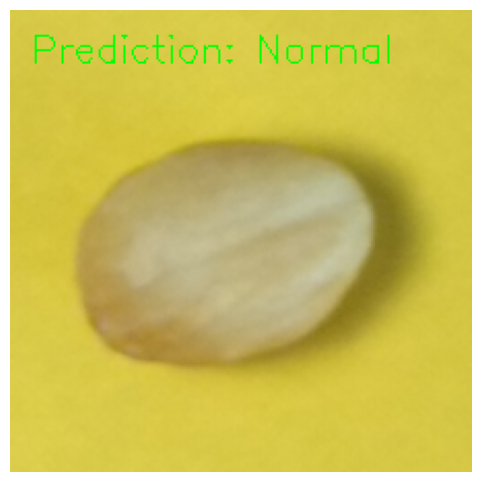

In [8]:
from anomalib.deploy.inferencers import OpenVINOInferencer
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Set paths ===
openvino_model_path = r"d:\Anomaly_detecion\weights\openvino\model.xml"
image_path = r"D:\Anomaly_detecion\hazelnut_toy\good\00.jpg"

# === Load and preprocess image ===
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = transform(image)
input_np = (input_tensor.permute(1, 2, 0).numpy() * 255).astype("uint8")

# === Run inference ===
inferencer = OpenVINOInferencer(
    path=openvino_model_path,
    device="CPU",
    task="classification"
)
results = inferencer.predict(image=input_np)

# === Get result label ===
label_text = "Anomalous" if results.pred_label == 1 else "Normal"
print("✅ Prediction Score:", results.pred_score)
print("✅ Prediction Label:", label_text)

# === Draw label on image ===
image_bgr = cv2.cvtColor(input_np, cv2.COLOR_RGB2BGR)
cv2.putText(
    image_bgr,
    f"Prediction: {label_text}",
    org=(10, 25),  # slightly higher since font is smaller
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=0.6,  # Smaller font size
    color=(0, 255, 0) if label_text == "Normal" else (0, 0, 255),
    thickness=1  # Thinner text to match smaller font
)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === Display with matplotlib ===
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()
